In [1]:
# %%
import time
import numpy as np
import pickle
from numpy.linalg import det

import CMINE_lib as CMINE
# from Guassian_variables import Data_guassian

import pandas as pd
from scipy.stats import multivariate_normal
import itertools

np.random.seed(37)
from scipy import stats
from sklearn.neighbors import KernelDensity

import math

import torch 
import torch.nn as nn

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    # TODO: torch.max(value, dim=None) threw an error at time of writing
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

class L1OutUB(nn.Module):  # naive upper bound
    def __init__(self, x_dim, y_dim, hidden_size):
        super(L1OutUB, self).__init__()
        y_dim = 1
        self.p_mu = nn.Sequential(nn.Linear(x_dim, hidden_size//2),
                                       nn.ReLU(),
                                       nn.Linear(hidden_size//2, y_dim))

        self.p_logvar = nn.Sequential(nn.Linear(x_dim, hidden_size//2),
                                       nn.ReLU(),
                                       nn.Linear(hidden_size//2, y_dim),
                                       nn.Tanh())

        self.p_mu_neg = nn.Sequential(nn.Linear(x_dim-1, hidden_size//2),
                                       nn.ReLU(),
                                       nn.Linear(hidden_size//2, y_dim))

        self.p_logvar_neg = nn.Sequential(nn.Linear(x_dim-1, hidden_size//2),
                                       nn.ReLU(),
                                       nn.Linear(hidden_size//2, y_dim),
                                       nn.Tanh())


    def get_mu_logvar(self, x_samples):
        mu = self.p_mu(x_samples)
        logvar = self.p_logvar(x_samples)
        return mu, logvar
    
    def get_mu_logvar_neg(self, x_samples):
        mu = self.p_mu_neg(x_samples)
        logvar = self.p_logvar_neg(x_samples)
        return mu, logvar

    def forward(self, x_samples, y_samples): # x_samples = s_t, a ; y_samples = s_{t+1}
        batch_size = y_samples.shape[0]
        #x_samples[:, 1].masked_fill_(x_samples[:, 1]!=0, float(0))
        cmi_dims =[]
        
        
        for k in range(y_samples.shape[1]):
            mu, logvar = self.get_mu_logvar(x_samples)
            

            positive = (- (mu - y_samples[:,k].unsqueeze(-1))**2 /2./logvar.exp() - logvar/2.).sum(dim = -1) #[nsample]

            negative = []
            for i in range(x_samples.shape[1]-1):
                result = []
                for j in range(x_samples.shape[1]): 
                    if j != i:
                        result.append(j)

                x_temp = torch.index_select(x_samples, dim=1, index=torch.tensor(result).cuda())
                #x_temp = x_samples.index_fill_(1, torch.tensor([i]).cuda(), float('0'))
                mu, logvar = self.get_mu_logvar_neg(x_temp)
                neg = (- (mu - y_samples[:,k].unsqueeze(-1))**2 /2./logvar.exp() - logvar/2.).sum(dim = -1) #[nsample]
                if i == 0:
                    negative = neg.unsqueeze(-1)
                else:
                    negative = torch.cat([negative, neg.unsqueeze(-1)], 1)
                    
            
            cmi_dim = (positive.unsqueeze(-1)- negative ).abs().mean(axis=0).cpu().detach().numpy()

            cmi_dims.append(cmi_dim)

        # mu_1 = mu.unsqueeze(1)          # [nsample,1,dim]
        # logvar_1 = logvar.unsqueeze(1)
        # y_samples_1 = y_samples.unsqueeze(0)            # [1,nsample,dim]
        # all_probs =  (- (y_samples_1 - mu_1)**2/2./logvar_1.exp()- logvar_1/2.).sum(dim = -1)  #[nsample, nsample]

        # diag_mask =  torch.ones([batch_size]).diag().unsqueeze(-1).cuda() * (-20.)
        # negative = log_sum_exp(all_probs + diag_mask,dim=0) - np.log(batch_size-1.) #[nsample]
        #print(( positive.unsqueeze(-1)- negative ).mean())
       
        return cmi_dims
    
    def loglikeli(self, x_samples, y_samples):
        x_samples = x_samples.clone()
        y_samples = y_samples.clone()
        
        num = y_samples.shape[1]
        for k in range(y_samples.shape[1]):
        
            mu, logvar = self.get_mu_logvar(x_samples)

            lg = (-(mu - y_samples[:,k].unsqueeze(-1))**2 /logvar.exp()-logvar).sum(dim=1).mean(dim=0)
            if  k == 0:
                lgs = lg
            else:
                lgs += lg

        del x_samples, y_samples
        torch.cuda.empty_cache()
        #print("lg", lg)
        return lgs/num
    
    def loglikeli_mask(self, x_samples, y_samples):
        negative = []
        x_samples = x_samples.clone()
        y_samples = y_samples.clone()
        num = y_samples.shape[1]
        for k in range(y_samples.shape[1]):
            for i in range(x_samples.shape[1]-1):
                result = []

                for j in range(x_samples.shape[1]): 
                    if j != i:
                        result.append(j)
                x_temp = torch.index_select(x_samples, dim=1, index=torch.tensor(result).cuda())
                #x_temp = x_samples.index_fill_(1, torch.tensor([i]).cuda(), float('0'))
                mu, logvar = self.get_mu_logvar_neg(x_temp)
                neg =  (-(mu - y_samples[:,k].unsqueeze(-1))**2 /logvar.exp()-logvar).sum(dim=-1) #(- (mu - y_samples)**2 /2./logvar.exp() - logvar/2.).sum(dim = -1) #[nsample]
                if i == 0:
                    negative = neg.unsqueeze(-1)
                else:
                    negative = torch.cat([negative, neg.unsqueeze(-1)], 1)
            if k == 0:
                negatives = negative.sum(dim=1).mean(dim=0)
            else:
                negatives += negative.sum(dim=1).mean(dim=0)
        del x_samples, y_samples
        torch.cuda.empty_cache()
        #print('mask', negative.sum(dim=1).mean(dim=0))
        return negatives/num

    def learning_loss(self, x_samples, y_samples):
        return  - self.loglikeli_mask(x_samples, y_samples)  - self.loglikeli(x_samples, y_samples)

In [3]:


torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True


In [4]:
Dim = 5
dataset = CMINE.create_dataset_DGP(GenModel="", Params="", Dim=5, N=64)
s_t = torch.from_numpy(dataset[0]).float().cuda()
s_next = torch.from_numpy(dataset[1]).float().cuda()
a = torch.from_numpy(dataset[2]).float().cuda()

In [5]:
s_next.shape

torch.Size([64, 10])

In [6]:
torch.cat([s_t,a], dim=1).shape

torch.Size([64, 11])

In [7]:
# %%
sample_dim = 2*Dim
batch_size = 64
hidden_size = 15
learning_rate = 0.005
training_steps = 40

cubic = False 

# %%
model = L1OutUB(sample_dim + 1, sample_dim, hidden_size).cuda()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# %%

# %%
mi_est_values = []

# %%
for step in range(training_steps):
    #batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size = batch_size, to_cuda = True, cubic = cubic)
    dataset = CMINE.create_dataset_DGP(GenModel="", Params="", Dim=Dim, N=64)
    s_t = torch.from_numpy(dataset[0]).float().cuda()
    s_next = torch.from_numpy(dataset[1]).float().cuda()
    a = torch.from_numpy(dataset[2]).float().cuda()
    
    batch_x = torch.cat([s_t,a], dim=1)
    batch_y = s_next
    model.eval()
    cmi = model(batch_x, batch_y)
    mi_est_values.append(cmi)
    #print(cmi)
    # %%
    model.train() 

    model_loss = model.learning_loss(batch_x, batch_y)

    optimizer.zero_grad()
    model_loss.backward(retain_graph=True)
    optimizer.step()

    del batch_x, batch_y
    torch.cuda.empty_cache()
#print("finish training for %s with true MI value = %f"%('LOO', 6.0))
print(np.array(mi_est_values).mean())

2778.7847


In [10]:
cmi_to_plot = np.array(mi_est_values).mean(axis=0)

In [8]:
np.array(mi_est_values).shape

(40, 10, 10)

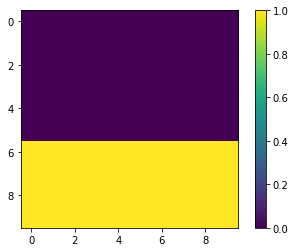

In [17]:
from matplotlib import pyplot as plt
plt.imshow(cmi_to_plot)
# first dimension: rows; second: columns
plt.colorbar()

In [14]:
cmi_to_plot[1]

array([23.203314 , 23.202826 , 23.202246 , 23.200102 , 23.195562 ,
       23.467264 , 23.712902 ,  4.7498884, 11.768938 , 12.568868 ],
      dtype=float32)

In [15]:
cmi_to_plot[cmi_to_plot<100]=0
cmi_to_plot[cmi_to_plot>=100]=1

In [16]:
cmi_to_plot

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)